In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 30 16:12:14 2019
Modified on Wed Dec 10 2025

@author: wlarsen
@modifier: Weidai Sun
"""

'\nCreated on Mon Sep 30 16:12:14 2019\n\n@author: wlarsen\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize

In [ ]:
# manually make variables for now, change to sys.arg later if needed

dir = '/content/drive/MyDrive/EEPS_634_Final/Panama_data/'
final_data = pd.DataFrame(columns=['date','names','dD','d18O','d18O_std','dD_std'])
df_name = dir+'HIDS2336_IsoWater_20251003_215334.csv'

numAvg = 5 # number of injections to use in average (from command line)

df = pd.read_csv(df_name,header=0,keep_default_na=False, na_values=["              "],index_col=0)
column_names = [df.columns.values[i].lstrip() for i in range(0,len(df.columns.values))] #extract column names, eleminate whitespace
df.columns = column_names # rename
#sample_names =  [df.loc[:,'Identifier 1'][i].lstrip() for i in range(0,len(df.loc[:,'Identifier 1']))] # extract sample names, eliminate whitespace


In [ ]:
## assign each set of injections to a "group"
# this is different from "Job" because it includes the 24 injections of 12+12 repeats, where job says its two different jobs
group = 1
grouplist = []
# Store the first index of the DataFrame to use in the loop
first_df_index = df.index[0]

for i in df.index:
    tempname = df.loc[i,"Identifier 1"]
    if i == first_df_index: # Check if it's the very first row of the DataFrame
        grouplist.append(group)
    else:
        tempnameprev = df.loc[i-1,"Identifier 1"]
        if ((df.loc[i,'Inj Nr'] == 1) & (tempname != tempnameprev)):
            group+=1
        grouplist.append(group)
df['group'] = grouplist

# assign analyte names to groups, count number of injections per group
names = []
lengths = []
for i in set(df['group']):
    tempdf = df[df['group']==i]
    if all(tempdf['Identifier 1']) == False:
        print(f'ERROR: Identifiers are not all the same within group #{i}')
        break
    tempname = list(tempdf.loc[:,'Identifier 1'])[0]
    names.append(tempname)
    lengths.append(tempdf.shape[0])
    print(f'{i}: {tempname} Inj: {tempdf.shape[0]}' )
groups = pd.DataFrame(index=sorted(df['group'].unique())) # this group df is the main output
groups['names']=names
groups['lengths']=lengths

1:                                     KD-1 Inj: 24
2:                                   IARO63 Inj: 12
3:                                   USGS47 Inj: 12
4:                                     RSIL Inj: 12
5:                                     KD-1 Inj: 8
6:                                   USGS48 Inj: 8
7:                    Drago 0.5m 15-Feb-2021 Inj: 8
8:               Drago 15-Mar-2021 Inj: 8
9:               Drago 0.5m 30-Mar-2021 Inj: 8
10:                    Drago 12-Apr-2021 Inj: 8
11:                                     KD-1 Inj: 8
12:                     Drago 27-Apr-2021 Inj: 8
13:                    Drago 11-May-2021 Inj: 8
14:                     Drago 0.5m 25-May-2021 Inj: 8
15:               Drago 0.5m 8-Jun-2021 Inj: 8
16:                Drago 5-Jul-2021 Inj: 8
17:                                     KD-1 Inj: 8
18:                                   USGS48 Inj: 8
19:                    Drago 20-Jul-2021 Inj: 8
20:               Drago 2-Aug-2021 Inj: 8
21:           

Memory Correction

In [ ]:
# methods
mem_mean_bool = True
mem_optimize_bool = True

memorysubset = [4,5] # runs to base the memory correction off of
othersubset = [2,3,6,7,8,9,10,11] # runs to apply the memory correction (dont include 1, because no prior injections)

memcoeffs = np.ones(24) # start memory coefficients as ones, i.e. no corrections

#isotope = 'd(D_H)Mean'
#isotope = 'd(18_16)Mean'

isotopememlist = ['dOmem','dDmem']

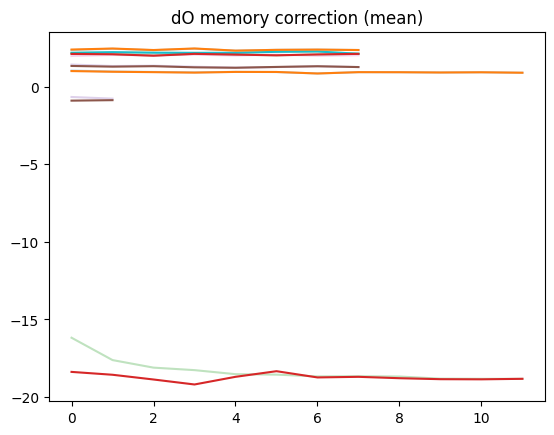

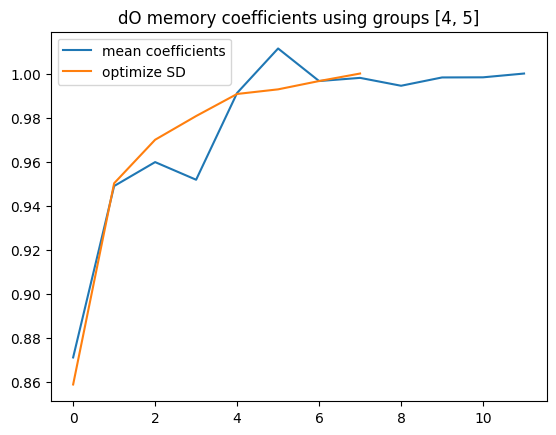

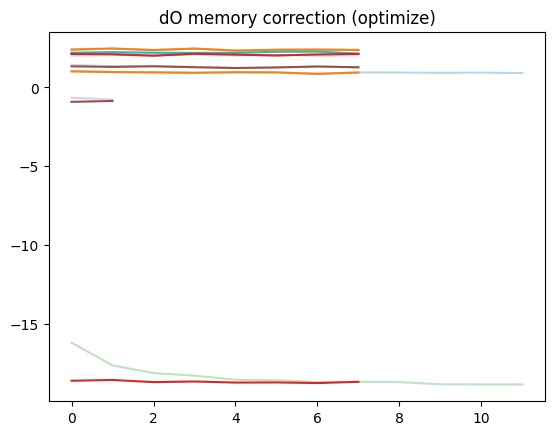

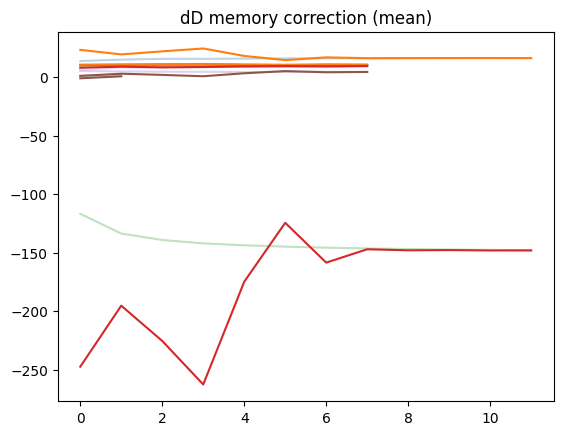

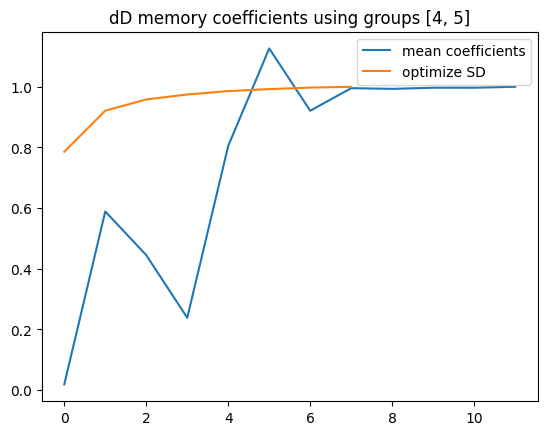

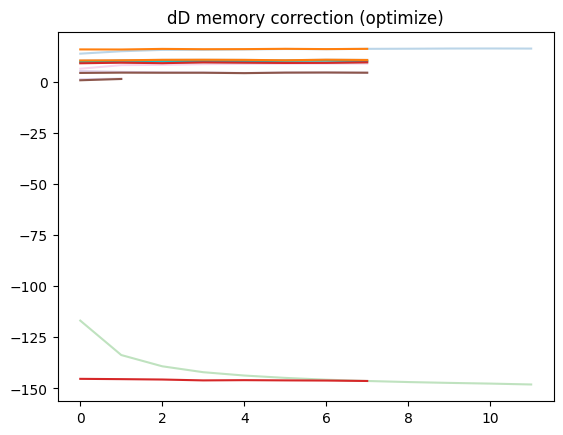

In [ ]:
for iindex,isotope in enumerate(['d(18_16)Mean','d(D_H)Mean']):
    memavgnum = 3 #how many of the last injections do we average to get the "end goal" to normalize to?

    # get lastvals, initial stdevs
    stdevs = []
    lasts = []
    coeffs = pd.DataFrame()
    for m in memorysubset:
        index = df[df['group']==m].index
        last = df.loc[index[0]-1,isotope] # last inj from previous group
        lasts.append(last)
        currentlast = df.loc[index[-1],isotope] # last inj from current group
    ## option to have the gradient set by an average of the last few, rather than juts the last value
    #    last = np.mean(df.loc[range((index[0]-1-memavgnum),(index[0]-1)),isotope])
    #    currentlast = np.mean((df.loc[index[range((-1-memavgnum),-1)],isotope]))
        gradient = last-currentlast
        tempcoeff = []
        for i in np.array(df.loc[index,isotope]):
            tempcoeff.append((last-i)/gradient)
        # pad to match max length
        max_len = coeffs.shape[0] if coeffs.shape[0] > 0 else len(tempcoeff)
        tempcoeff = tempcoeff + [np.nan]*(max_len - len(tempcoeff)) if len(tempcoeff) < max_len else tempcoeff
        coeffs[m] = tempcoeff

    if mem_mean_bool == True:
        isotopemem = isotopememlist[iindex]+'_mean'
        df[isotopemem] = df[isotope]

        meancoeffs = np.array([np.mean(coeffs.iloc[i]) for i in coeffs.index])


        def memfunc(subset, lastval, trynum=12, df=df, isotope=isotope, memcoeffs=None):
            # raw injections for that group
            raw = np.asarray(df.loc[df['group'] == subset, isotope])

            # choose coefficients: if none passed, fall back to meancoeffs
            if memcoeffs is None:
                coeffs = np.asarray(meancoeffs)
            else:
                coeffs = np.asarray(memcoeffs)

            # make sure raw and coeffs have the same length
            cutoff = min(len(raw), len(coeffs), trynum)
            raw = raw[:cutoff]
            coeffs = coeffs[:cutoff]

            return raw + (1 - coeffs) * (raw - lastval)


        trynum=4
        # apply new memory coefficients to all data
        plt.figure()
        plt.title(f'{isotopemem[0:2]} memory correction (mean)')
        for g in othersubset:
            index = df[df['group']==g].index
            last = df.loc[index[0]-1,isotope]
            rawdata = df.loc[df['group']==g,isotope]
            plt.plot(range(0,len(rawdata)),rawdata,alpha=0.3)
            plt.plot(memfunc(g,last,isotope=isotope,trynum=len(index)))

            df.loc[index,isotopemem] = memfunc(g,last,isotope=isotope,trynum=len(index))

    ### okay, we did it using the means, now let's do the optimization to minimize shared SD
    if mem_optimize_bool == True:
        isotopemem = isotopememlist[iindex]+'_optimize'
        df[isotopemem] = df[isotope]

        # how many injections are available in the memory groups?
        n_inj = min(len(df.loc[df['group'] == m, isotope]) for m in memorysubset)

        def F(x):
                vals = [np.array(df.loc[df['group']==subset, isotope]) for subset in memorysubset]
                val_temp = []
                for i, j in zip(vals, lasts):
                    temp = []
                    # only use the first n_inj injections
                    for k in range(n_inj):
                        xi = i[k] + (1 - x[k]) * (i[k] - j)
                        temp.append(xi)

                    temp = np.array(temp)
                    val_temp.append(temp)
                val_temp = np.array(val_temp)

                raw_sd1 = np.std(val_temp[0])
                raw_sd2 = np.std(val_temp[1])
                if len(memorysubset) > 2:
                    raw_sd3 = np.std(val_temp[2])

                SD = (raw_sd1**0.5 + raw_sd2**0.5)**0.5
                if len(memorysubset) > 2:
                    SD = (raw_sd1**0.5 + raw_sd2**0.5 + raw_sd3**0.5)**0.5

                return SD

        # x now has length n_inj, not 24
        x = np.ones(n_inj)
        boundslist = []
        for i in range(n_inj):
            boundslist.append([0.5 + 0.02*i, 1])  # set bounds

        dictlist = []
        for idx in range(1, n_inj-1):
            # capture idx in the lambda default arg
            dictlist.append({'type': "ineq",
                             'fun': lambda x, idx=idx: np.array(x[idx] - x[idx-1])})
        dictlist.append({'type': "eq",
                         'fun': lambda x: np.array(x[n_inj-1] - 1)})
        dictlist.append({'type': "ineq",
                         'fun': lambda x: np.array(x[0] - 0.5)})

        x0 = [0.5 + 0.02*i for i in range(n_inj)]

        xnew = minimize(F, x0=x0, bounds=boundslist, constraints=dictlist)

        plt.figure()
        plt.title(f'{isotopemem[0:2]} memory coefficients using groups {memorysubset}')
        plt.plot(meancoeffs)
        plt.plot(xnew['x'])
        plt.legend(['mean coefficients','optimize SD'])

        # apply new memory coefficients to all data
                # apply new memory coefficients to all data
        plt.figure()
        plt.title(f'{isotopemem[0:2]} memory correction (optimize)')
        for g in othersubset:
            index   = df[df['group'] == g].index
            last    = df.loc[index[0]-1, isotope]
            rawdata = df.loc[df['group'] == g, isotope]

            # raw data plot
            plt.plot(range(len(rawdata)), rawdata, alpha=0.3)

            # corrected data using optimized coeffs
            corrected = memfunc(g, last,
                                trynum=len(index),
                                df=df,
                                isotope=isotope,
                                memcoeffs=xnew['x'])

            # plot corrected (length may be < len(index))
            plt.plot(range(len(corrected)), corrected)

            # assign only to the first len(corrected) rows of this group
            df.loc[index[:len(corrected)], isotopemem] = corrected


    # begin averaging
    avglist = []
    avgnomemlist = []
    avgindexlist = []
    if mem_mean_bool == True:
        isotopemem = isotopememlist[iindex]+'_mean'
        for g in groups.index:
            index = df[df['group']==g].index
            avgindexnomem = range(index[-1]-numAvg,index[-1])
            avgindex = range(index[-1]-numAvg,index[-1])
            avgindexlist.append(np.mean(avgindex))

            avgnomem = np.mean(df.loc[avgindex,isotope])
            avgnomemlist.append(avgnomem)
            avg = np.mean(df.loc[avgindex,isotopemem])
            avglist.append(avg)

        groups[isotope] = avgnomemlist
        groups[isotopemem] = avglist
        groups['avgindex'] = avgindexlist

    avglist = []
    avgnomemlist = []
    avgindexlist = []
    if mem_optimize_bool == True:
        isotopemem = isotopememlist[iindex]+'_optimize'
        for g in groups.index:
            index = df[df['group']==g].index
            avgindexnomem = range(index[-1]-numAvg,index[-1])
            avgindex = range(index[-1]-numAvg,index[-1])
            avgindexlist.append(np.mean(avgindex))

            avgnomem = np.mean(df.loc[avgindex,isotope])
            avgnomemlist.append(avgnomem)
            avg = np.mean(df.loc[avgindex,isotopemem])
            avglist.append(avg)

        groups[isotope] = avgnomemlist
        groups[isotopemem] = avglist
        groups['avgindex'] = avgindexlist


Drift correction

In [ ]:
groups['names'] = groups['names'].astype(str).str.strip()
print(groups['names'].unique())

['KD-1' 'IARO63' 'USGS47' 'RSIL' 'USGS48' 'Drago 0.5m 15-Feb-2021'
 'Drago 15-Mar-2021' 'Drago 0.5m 30-Mar-2021' 'Drago 12-Apr-2021'
 'Drago 27-Apr-2021' 'Drago 11-May-2021' 'Drago 0.5m 25-May-2021'
 'Drago 0.5m 8-Jun-2021' 'Drago 5-Jul-2021' 'Drago 20-Jul-2021'
 'Drago 2-Aug-2021' 'Drago 0.5m 16-Aug-2021' 'Drago 0.5m 1-Sep-2021'
 'Drago 16-Sep-2021' 'Drago 0.5m 28-Sep-2021' 'Drago 0.5m 12-Oct-2021'
 'Stri 0.5m 21-Jan-2020' 'Stri 0.5m 4-Feb-2020' 'Stri 0.5m 18-Feb-2020'
 'Stri 0.5m 3-Mar-2020' 'ST 200929' 'Stri OVD 6-Oct-2020']


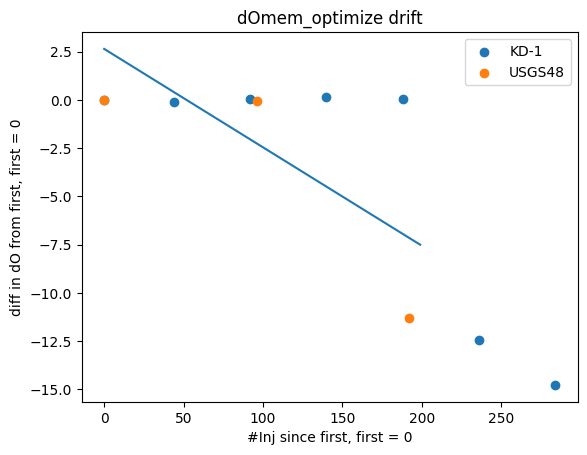

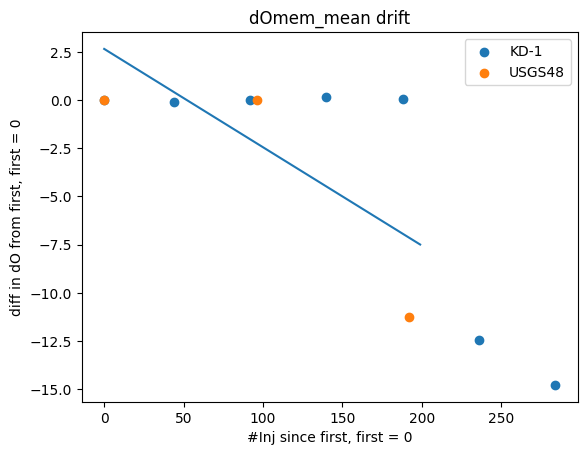

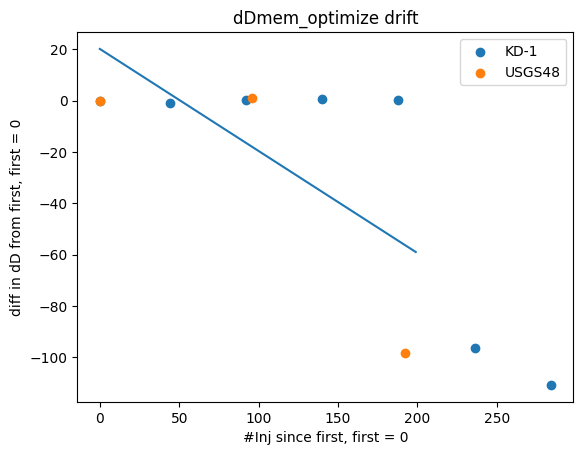

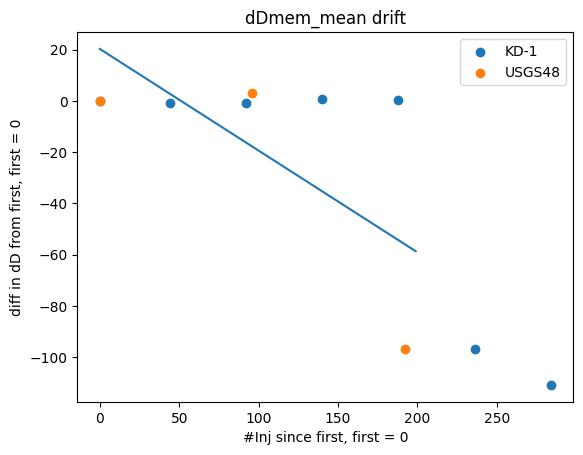

In [ ]:
# choose which mem correction you want

if mem_mean_bool == True:
    correctionchoice = ['mean']
if mem_optimize_bool == True:
    correctionchoice = ['optimize']
if (mem_mean_bool & mem_optimize_bool)== True:
    correctionchoice = ['optimize','mean'] #'mean'
isotopelist = [i+'_'+j for i in ['dOmem','dDmem'] for j in correctionchoice]

driftnames = ['KD-1', 'USGS48']
driftslopes = []
isotopelist = [i + '_' + j for i in ['dOmem', 'dDmem'] for j in correctionchoice]

driftnames = ['KD-1', 'USGS48']
driftslopes = []

for isotope in isotopelist:
    plt.figure()
    totalx = []
    totaly = []

    for d in driftnames:
        # subset for this drift standard, and drop rows with NaN in this isotope
        tempdf = groups[(groups['names'] == d) & groups[isotope].notna()]

        if tempdf.empty:
            print(f"Warning: no valid {isotope} data for drift standard {d} in this run – skipping it.")
            continue

        x = tempdf['avgindex'].to_numpy()
        y = tempdf[isotope].to_numpy()

        # relative to the first measurement of this standard
        x_rel = x - x[0]
        y_rel = y - y[0]

        totalx.extend(x_rel)
        totaly.extend(y_rel)

        plt.scatter(x_rel, y_rel, label=d)

    # if we don't have at least 2 points total, we can't fit a drift line
    if len(totalx) < 2:
        print(f"Not enough points to fit drift for {isotope}; skipping drift correction.")
        continue

    plt.title(f'{isotope} drift')
    plt.xlabel('#Inj since first, first = 0')
    plt.ylabel(f'diff in {isotope[0:2]} from first, first = 0')
    plt.legend()

    # fit drift
    slope, intercept, r_value, p_value, std_err = stats.linregress(totalx, totaly)
    xarray = range(0, 200)
    plt.plot(xarray, xarray * slope + intercept)

    driftslopes.append(slope)

    # apply drift correction to ALL groups for this isotope
    groups[isotope + '_corr'] = groups[isotope] - groups['avgindex'] * slope

Calibration

In [ ]:
#### Water standards
waterstandards = {'RSIL':{'longname':'USGS RSIL W-67400','dO':-1.97,'dOstd':0.02,'dD':1.25,'dDstd': 0.4},
                  'isoblue':{'longname': 'IA-R064', 'dO': -12.34, 'dOstd': 0, 'dD': -98.32, 'dDstd': 0},
                  'IARO64':{'longname': 'IA-R064', 'dO': -12.34, 'dOstd': 0, 'dD': -98.32, 'dDstd': 0},
                  'isored':{'longname': 'IA-R063', 'dO': -0.41, 'dOstd': 0, 'dD': 11.26, 'dDstd': 0},
                  'IARO63':{'longname': 'IA-R063', 'dO': -0.41, 'dOstd': 0, 'dD': 11.26, 'dDstd': 0},
                  'ice':{'longname': 'Iceland bottled', 'dO': -8.5, 'dOstd': 0.1, 'dD':-57.1, 'dDstd': 0.2} ,
                  'kona':{'longname': 'Kona Deep bottled', 'dO': -0.3, 'dOstd': 0.1, 'dD': -1.2, 'dDstd': 0.2} ,
                  'KONA':{'longname': 'Kona Deep bottled', 'dO': -0.3, 'dOstd': 0.1, 'dD': -1.2, 'dDstd': 0.2} ,
                  'fiji':{'longname':'Fiji bottled', 'dO': -6.7, 'dOstd': 0.1, 'dD': -44.2, 'dDstd': 0.2} ,
                  'kirk':{'longname': 'Kirkland bottled', 'dO': -3, 'dOstd': 0.1, 'dD': -19.4, 'dDstd': 0.2},
                  'lt2':{'longname': 'Lab tap 2', 'dO': -3.9, 'dOstd': 0.1, 'dD': -21.6, 'dDstd': 0.2},
                  'LT-2':{'longname': 'Lab tap 2', 'dO': -3.9, 'dOstd': 0.1, 'dD': -21.6, 'dDstd': 0.2},
                  'VSMOW':{'longname': 'Vienna Standard Mean Ocean Water', 'dO': 0, 'dOstd': 0, 'dD': 0, 'dDstd': 0},
                  'SLAP':{'longname': 'Standard Light Antarctic PRecipitation', 'dO': -55.5, 'dOstd': 0, 'dD': -428, 'dDstd': 0},
                  'KD-1':{'longname': 'Kona Deep bottled', 'dO': -0.3, 'dOstd': 0.1, 'dD': -1.2, 'dDstd': 0.2},
                  'USGS47':{'longname': 'Lake Louise Drinking Water', 'dO': -19.8, 'dOstd': 0.02, 'dD': -150.2, 'dDstd': 0.5},
                  'USGS48':{'longname': 'Puerto Rico Precipitation', 'dO': -2.224, 'dOstd': 0.012, 'dD': -2.0, 'dDstd': 0.4}}


waterdf = pd.DataFrame.from_dict(waterstandards,orient='index')

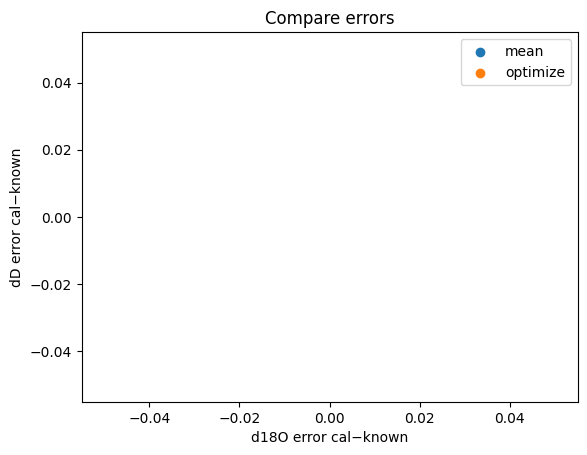

In [ ]:
#### MAKE A CALIBRATION
# clean up names in groups and waterdf so they match
groups['names'] = groups['names'].astype(str).str.strip()
waterdf.index = waterdf.index.astype(str).str.strip()

plt.figure()

for method in ['mean', 'optimize']:

    # map group names to true values; unknowns become NaN automatically
    groups['dOknown'] = groups['names'].map(waterdf['dO'])
    groups['dDknown'] = groups['names'].map(waterdf['dD'])


    measuredO = f'dOmem_{method}_corr'
    measuredD = f'dDmem_{method}_corr'

    # only use rows where we actually know the true value (i.e., standards)
    maskO = groups['dOknown'].notna()
    maskD = groups['dDknown'].notna()

    # --- δ18O calibration ---
    slopeO, interceptO, r_valueO, p_valueO, std_errO = stats.linregress(
        groups.loc[maskO, measuredO],
        groups.loc[maskO, 'dOknown']
    )
    groups[f'dOcal_{method}'] = groups[measuredO] * slopeO + interceptO
    groups[f'dOerr_{method}'] = groups[f'dOcal_{method}'] - groups['dOknown']

    # --- δD calibration ---
    slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(
        groups.loc[maskD, measuredD],
        groups.loc[maskD, 'dDknown']
    )
    groups[f'dDcal_{method}'] = groups[measuredD] * slopeD + interceptD
    groups[f'dDerr_{method}'] = groups[f'dDcal_{method}'] - groups['dDknown']

# plot comparison of errors for the two methods, if you want:
plt.title('Compare errors')
plt.scatter(groups['dOerr_mean'], groups['dDerr_mean'])
plt.scatter(groups['dOerr_optimize'], groups['dDerr_optimize'])
plt.xlabel('d18O error cal−known')
plt.ylabel('dD error cal−known')
plt.legend(['mean', 'optimize'])


**Save the data in a new sheet**

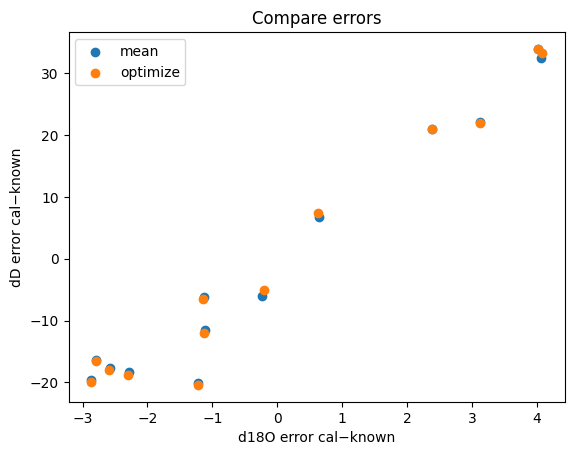

In [ ]:
# 1. Clean names so they match the water standards table
groups['names'] = groups['names'].astype(str).str.strip()
waterdf.index    = waterdf.index.astype(str).str.strip()

# 2. Map group names → known d18O / dD once
groups['dOknown'] = groups['names'].map(waterdf['dO'])
groups['dDknown'] = groups['names'].map(waterdf['dD'])

plt.figure()

# if you only turned on one of the memory options, respect that
if mem_mean_bool and not mem_optimize_bool:
    methods = ['mean']
elif mem_optimize_bool and not mem_mean_bool:
    methods = ['optimize']
else:
    methods = ['mean', 'optimize']

for method in methods:

    measuredO = f'dOmem_{method}_corr'
    measuredD = f'dDmem_{method}_corr'

    # skip this method if those columns don't exist
    if measuredO not in groups.columns or measuredD not in groups.columns:
        print(f"Skipping {method}: {measuredO} or {measuredD} not found in groups.")
        continue

    # -------- δ18O calibration --------
    maskO = groups['dOknown'].notna() & groups[measuredO].notna()
    if maskO.sum() < 2:
        print(f"Not enough standards with valid d18O for method '{method}' – skipping δ18O calibration.")
    else:
        slopeO, interceptO, r_valueO, p_valueO, std_errO = stats.linregress(
            groups.loc[maskO, measuredO],
            groups.loc[maskO, 'dOknown']
        )
        groups[f'dOcal_{method}'] = groups[measuredO] * slopeO + interceptO
        groups[f'dOerr_{method}'] = groups[f'dOcal_{method}'] - groups['dOknown']

    # -------- δD calibration --------
    maskD = groups['dDknown'].notna() & groups[measuredD].notna()
    if maskD.sum() < 2:
        print(f"Not enough standards with valid dD for method '{method}' – skipping δD calibration.")
    else:
        slopeD, interceptD, r_valueD, p_valueD, std_errD = stats.linregress(
            groups.loc[maskD, measuredD],
            groups.loc[maskD, 'dDknown']
        )
        groups[f'dDcal_{method}'] = groups[measuredD] * slopeD + interceptD
        groups[f'dDerr_{method}'] = groups[f'dDcal_{method}'] - groups['dDknown']

# -------- error comparison plot (only use rows with non-NaN errors) --------
plt.title('Compare errors')

if 'dOerr_mean' in groups.columns and 'dDerr_mean' in groups.columns:
    mask_mean = groups['dOerr_mean'].notna() & groups['dDerr_mean'].notna()
    plt.scatter(groups.loc[mask_mean, 'dOerr_mean'],
                groups.loc[mask_mean, 'dDerr_mean'],
                label='mean')

if 'dOerr_optimize' in groups.columns and 'dDerr_optimize' in groups.columns:
    mask_opt = groups['dOerr_optimize'].notna() & groups['dDerr_optimize'].notna()
    plt.scatter(groups.loc[mask_opt, 'dOerr_optimize'],
                groups.loc[mask_opt, 'dDerr_optimize'],
                label='optimize')

plt.xlabel('d18O error cal−known')
plt.ylabel('dD error cal−known')
plt.legend()

In [ ]:
standard_names = list(waterstandards.keys())

samples = groups[~groups['names'].isin(standard_names)].copy()

# choose base df: samples only or all groups
base = samples  # or `groups` if you want standards too

results = base.reset_index().rename(columns={'index': 'group_id'})

results = results[[
    'group_id',
    'names',
    'lengths',          # number of injections per group (if you created this)
    'avgindex',
    'dOcal_mean',
    'dDcal_mean',
    'dOcal_optimize',
    'dDcal_optimize'
]].rename(columns={
    'names': 'sample_name',
    'dOcal_mean': 'd18O_cal_mean',
    'dDcal_mean': 'dD_cal_mean',
    'dOcal_optimize': 'd18O_cal_opt',
    'dDcal_optimize': 'dD_cal_opt'
})

results.to_csv('/content/drive/MyDrive/EEPS_634_Final/Calibrated_data/Panama_isotopes_calibrated_20251003.csv', index=False)